# K-means & 階層的クラスタリング

このHands-onでは下記の2種類のデータを用いて，K-meansと階層的クラスタリングを体験する．
* 人工的な2次元データ
* とある購買データ

Hands-onに先立って，必要なライブラリを読み込んでおこう．

In [1]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 機械学習用ライブラリsklearnのKmeansクラス
from sklearn.cluster import KMeans

# 距離行列の計算のためのライブラリ
import scipy.spatial.distance as distance

# 階層的クラスタリング用のライブラリ
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# グラフ描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set(style='ticks')
%matplotlib inline


# 警告文を表示させないおまじない
import warnings
warnings.filterwarnings('ignore')


---


## 例題1: 人工データに対するK-meansクラスタリング

K-meansクラスタリングの効果や特徴を知るために，実際にK-meansを使ってみよう．

例題1で用いるデータは[University of Eastern Finlandの計算学部が公開しているデータセット](http://cs.joensuu.fi/sipu/datasets/)である．
このデータは人工的に作られた5000個の2次元データで，各次元に特に意味はない．

まずは以下のコードを実行して，``s1_df``変数にデータを読み込もう．

In [2]:
url = "http://cs.joensuu.fi/sipu/datasets/s1.txt"
s1_df = pd.read_table(url, sep="\s+", header=None, names=['x', 'y'])

# 最初の10件のデータを表示
s1_df.head(10)

,x,y
0,664159,550946
1,665845,557965
2,597173,575538
3,618600,551446
4,635690,608046
5,588100,557588
6,582015,546191
7,604678,574577
8,572029,518313
9,604737,574591


データの傾向を見るために，XY平面にデータをプロットしてみよう
下記のコードを実行すると，データの散布図を表示できる．

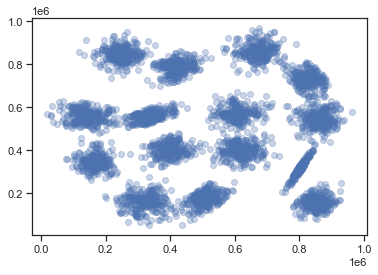

In [3]:
plt.scatter(s1_df.x, s1_df.y, alpha=0.3)
plt.show()

散布図を見ると，このデータセットの特徴が分かる．
目視レベルでは，データは**15個**のクラスタに分かれているように見える．

では，K-meansクラスタリングによって，目論見どおりにデータを15個のクラスタに分けられるか試してみよう．
以下のコードを実行する．

In [4]:
# クラスタリングを実行
model = KMeans(n_clusters=15, init='random')
model.fit(s1_df)

KMeans(init='random', n_clusters=15)

たった2行でクラスタリングが完了した．
クラスタリング結果は`model`が保持している．
各データがどのクラスタに分類されたかを抽出するには，以下のコードを実行する．

In [5]:
# 結果を格納
labels = model.labels_

# 表示
labels

array([ 8,  8,  8, ..., 10, 10, 10], dtype=int32)

K-meansクラスタリングの結果を踏まえて，散布図を色分けしてみよう．
今回の分析ではクラスタの数が15と多いので，下記のコードを実行して色分けのための準備を行う．

下記コードを実行して，散布図を15のグループごとに色分けを行ってみよう．
K-meansクラスタリングは，目論見どおりにデータを分割できていただろうか？（[★Quiz 3](#C3-Q3)，[★Quiz 4](#C3-Q4)）

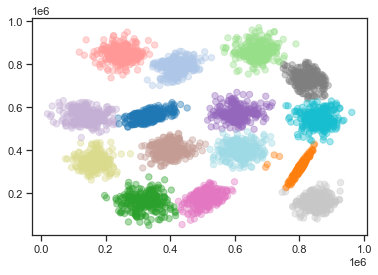

In [6]:
plt.scatter(
    s1_df.x, s1_df.y,
    c=labels, # クラスタに応じて色分け
    alpha=0.4, # 透明度
    s=40, # マーカーのサイズ
    cmap="tab20_r" # カラーパレット（20色対応）
)


---


## 例題2: とある購買データに対する階層的クラスタリング

次はあるeコマースサイトにおける購買データを用いて，階層的クラスタリングを用いる例題に取り組んでみよう．
まずは何も考えずに，以下のコードを実行してHands-onで用いるデータをダウンロードしよう．

In [7]:
# zipファイルをダウンロードし解凍
!wget https://gihyo.jp/assets/files/book/2014/978-4-7741-6674-2/download/DM_sampledata.zip
!unzip DM_sampledata.zip

--2025-03-18 15:22:06--  https://gihyo.jp/assets/files/book/2014/978-4-7741-6674-2/download/DM_sampledata.zip
gihyo.jp (gihyo.jp) をDNSに問いあわせています... 172.67.22.15, 104.22.59.251, 104.22.58.251
gihyo.jp (gihyo.jp)|172.67.22.15|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 41124 (40K) [application/zip]
`DM_sampledata.zip' に保存中

DM_sampledata.zip   100%[===================>]  40.16K  --.-KB/s 時間 0s         

2025-03-18 15:22:06 (111 MB/s) - `DM_sampledata.zip' へ保存完了 [41124/41124]

Archive:  DM_sampledata.zip
  inflating: DM_sampledata/ch10_hbayes.stan  
  inflating: DM_sampledata/ch3_2_2.txt  
  inflating: DM_sampledata/ch3_4_1.txt  
  inflating: DM_sampledata/ch4_3_2.txt  
  inflating: DM_sampledata/ch5_3.txt  
  inflating: DM_sampledata/ch6_4_1.txt  
  inflating: DM_sampledata/ch6_4_2.txt  
  inflating: DM_sampledata/ch7_3_2.txt  
  inflating: DM_sampledata/ch8_test.txt  
  inflating: DM_sampledata/ch8_test_label.txt  
  inflating: DM_sampledata/ch8_train.txt  
  in

次にダウンロードしたデータをデータフレーム化して，`e_commerce_df`変数に代入する．

In [8]:
# データをpandasのデータフレームとして読み込む
e_commerce_df = pd.read_table("DM_sampledata/ch5_3.txt", header=0, sep=" ")

# ファイルを読み込んだので，元ファイル/ディレクトリを削除しておく
!rm -rf DM_sampledata.zip DM_sampledata

変数``e_commerce_df``に読み込まれたデータフレームには，
* 書籍
* 衣服
* 化粧品
* 食料品
* 飲料

を1年間で何回購入したかについて，100名の顧客のデータが記録されている（このデータは[書籍「手を動かしながら学ぶビジネスに活かすデータマイニング」のサポートページにて公開されているデータ](https://gihyo.jp/book/2014/978-4-7741-6674-2/support)である）．

以下のコードを実行し，中身を確認してみよう．

In [9]:
# 最初の10件を表示
e_commerce_df.head()

,books,cloths,cosmetics,foods,liquors
0,43,0,3,4,10
1,25,5,5,3,11
2,19,0,2,3,8
3,31,3,3,4,5
4,46,9,2,5,7


### データ間の距離の計算

Pythonで階層的クラスタリングを実行するには，`scipy`ライブラリの``linkage``関数を用いるのが簡単だ．
``linkage``関数は入力（第1引数）として **ベクトル間の距離（を格納した行列データ）** が必要となる．
ここでベクトルとは，n個の特徴量からなるデータを意味する．
今回の``e_commerce_df``のデータフレームでは，1行1行が1名の顧客情報を表すベクトルデータとなる．
では，距離の情報を用意しよう．

正攻法でやるならば，100行ある``e_commerce_df``の顧客データのすべての組み合わせを比較して，各顧客ベクトルの距離を計算する必要がある．
`scipy`ライブラリはそれを簡単に実行してくれる便利な関数``distance.pdist``を提供している．

以下のコードを実行してベクトル間の距離を計算してみよう（[★Quiz 1](#C3-Q1)，[★Quiz 2](#C3-Q2)）．

In [10]:
# pdist関数を使い，全ベクトル間の距離を計算．距離の定義にはユークリッド距離を用いる
dist_matrix = distance.pdist(e_commerce_df, metric='euclidean')

# 距離行列を表示
pd.DataFrame(distance.squareform(dist_matrix))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,18.841444,24.124676,13.341664,10.049876,18.708287,14.628739,41.388404,13.228757,9.486833,...,8.426150,19.442222,14.933185,35.270384,5.744563,12.124356,23.452079,18.920888,44.068129,17.378147
1,18.841444,0.000000,8.888194,9.000000,22.045408,11.789826,22.248595,25.416530,25.179357,23.302360,...,15.427249,15.968719,17.663522,49.386233,18.920888,16.431677,17.748239,9.110434,26.589472,23.216374
2,24.124676,8.888194,0.000000,12.806248,28.548205,13.416408,29.866369,25.238859,30.347982,27.856777,...,21.283797,22.583180,23.388031,56.797887,24.515301,20.024984,24.083189,12.247449,26.191602,30.033315
3,13.341664,9.000000,12.806248,0.000000,16.340135,7.071068,19.390719,29.376862,18.193405,15.556349,...,9.327379,13.564660,11.958261,44.810713,12.124356,7.937254,17.146428,7.348469,32.341923,18.654758
4,10.049876,22.045408,28.548205,16.340135,0.000000,20.856654,8.185353,39.597980,12.409674,8.426150,...,7.874008,14.525839,12.884099,28.583212,6.000000,13.190906,18.193405,19.261360,43.162484,8.888194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.124356,16.431677,20.024984,7.937254,13.190906,9.539392,18.357560,34.146742,11.661904,9.746794,...,9.055385,14.106736,8.485281,40.484565,8.831761,0.000000,18.466185,13.228757,37.881394,15.459625
96,23.452079,17.748239,24.083189,17.146428,18.193405,18.708287,16.000000,23.811762,24.269322,22.315914,...,16.583124,5.830952,16.155494,40.570926,19.672316,18.466185,0.000000,13.928388,27.166155,12.727922
97,18.920888,9.110434,12.247449,7.348469,19.261360,10.198039,20.928450,23.216374,23.643181,20.297783,...,12.529964,11.832160,15.394804,47.138095,16.822604,13.228757,13.928388,0.000000,26.758176,19.697716
98,44.068129,26.589472,26.191602,32.341923,43.162484,30.854497,41.158231,8.185353,47.021272,45.563143,...,37.960506,29.933259,37.054015,67.216070,42.178193,37.881394,27.166155,26.758176,0.000000,39.597980


100行あるベクトルデータのすべての組み合わせについて距離を計算した結果（距離行列）が``dist_matrix``として得られた．
この距離行列を使って階層的クラスタリングを実行してみよう．

### 階層的クラスタリングの実行

講義でも述べたように，階層的クラスタリングではクラスタの作り方の基準として
* 最長距離法（complete linkage method）
* 最短距離法（single linkage method）
* 重心法（centroid method）
* 群平均法（group average method）
* ウォード法（Ward's method）

などがある．
今回はウォード法を使ってみよう．
以下のコードを実行して，ウォード法を用いた階層的クラスタリングを適用する．

In [11]:
e_commerce_result = linkage(dist_matrix, method="ward")

階層的クラスタリングの結果が変数``e_commerce_result``に格納された．

階層的クラスタリングにおいて，各要素（ベクトル）が徐々に併合されていく結果を示したものを**デンドログラム**と呼ぶ．
以下のコードを実行し，デンドログラムを表示させてみよう．

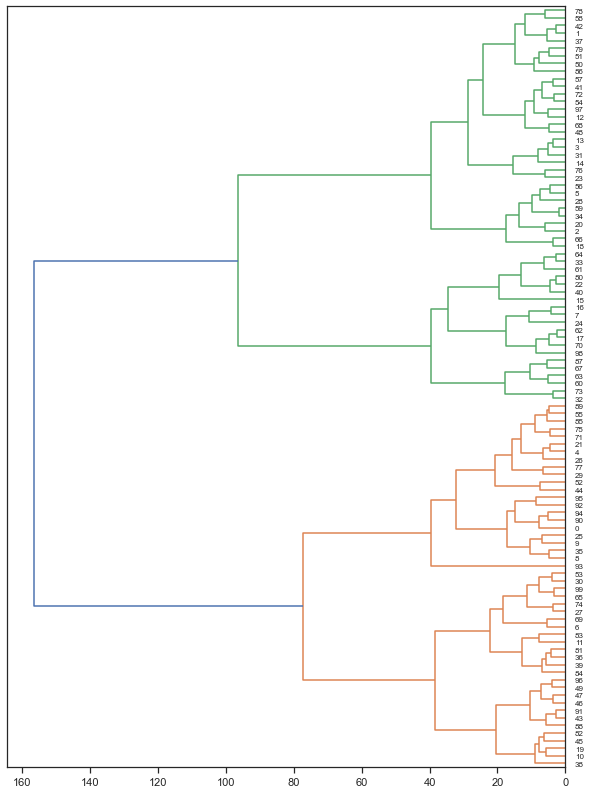

In [12]:
# 図の大きさの設定
plt.figure(figsize=(10, 14))

# 図の表示
fig = dendrogram(e_commerce_result,
                 leaf_font_size=8, orientation='left')
plt.show()

デンドログラムが表示されると，階層的クラスタリングを実行したという気分になる（[★Quiz 6](#C3-Q6)）．

今回は顧客の一人一人について私たちは特に知識がないため，この図を眺めてもよく分からない．
そこで，適当な深さでデンドログラムの枝を切って，各要素をクラスタに分けてみよう．
その上で，各クラスタに入っている要素がどのような性質を持っているかを分析してみよう．

デンドログラムの枝を切り，指定したクラスタ数に分割するには``cutree``関数を用いる．
``k``に数値を指定すると，デンドログラムをその数のクラスタに分割することができる．

In [13]:
# 4つのクラスタに分割
e_commerce_cluster = cut_tree(e_commerce_result, n_clusters=4)

# 最初の10件のみ表示
e_commerce_cluster[:10, 0]

array([0, 1, 1, 1, 0, 1, 2, 3, 0, 0])

変数``e_commerce_cluster``に100名の顧客のクラスタ割り当て番号が格納された．

さて，クラスタリングの結果は変数``e_commerce_cluster``に得られたが，各クラスタがどのような購買傾向を持っているかを分析するには，``e_commerce_df``データと照らし合わせる必要がある．
そこで，以下のコードを実行して，``e_commerce_cluster``と``e_commerce_df``を結合してみよう．

In [14]:
# 結合
new_e_commerce_df = e_commerce_df.assign(
    cluster_id = e_commerce_cluster[:, 0]
)

# 先頭の数件のみ表示
new_e_commerce_df.head()

,books,cloths,cosmetics,foods,liquors,cluster_id
0,43,0,3,4,10,0
1,25,5,5,3,11,1
2,19,0,2,3,8,1
3,31,3,3,4,5,1
4,46,9,2,5,7,0


各顧客データがどのクラスタに分類するかのデータが得られた．
このデータを用いて，クラスタ毎に書籍の平均購買数，衣類の平均購買数などを調べてみよう．

今回の分析のように，クラスタ毎に何らかの情報をまとめて計算することを**集約演算**と呼ぶ．
やや複雑に見えるが，以下のコードを実行してみてよう．

In [15]:
new_e_commerce_df.groupby(
    'cluster_id' # cluster_idでデータをまとめる
).agg(
    'mean' # まとまり毎に平均値を算出
)

,books,cloths,cosmetics,foods,liquors
cluster_id,,,,,
0,48.363636,8.454545,4.636364,5.636364,3.863636
1,26.562500,6.187500,4.500000,4.750000,5.531250
2,35.923077,17.730769,4.423077,5.000000,6.923077
3,9.200000,14.400000,5.350000,4.250000,8.400000


クラスタ毎に書籍，衣類，化粧品，食料品，飲料の平均購買数が求まった．
ユーザの購買傾向がクラスタ毎に少しずつ異なることが確認できる（[★Quiz 5](#C3-Q5)）．


---


## クイズ
※ 以下のクイズの回答にGoogle Colaboratoryを使いたい方は[コチラ](https://colab.research.google.com/github/hontolab-courses/ml-lecturenote/blob/main/content/quiz/kmeans-and-hierarchical-clustering.ipynb)をクリック．

(C3-Q1)=
### Q1: ユークリッド距離とコサイン類似度

以下の図のように，2次元のユークリッド空間上に，13個のデータ点が図のように分布している状況を考える（各点の座標については，下記コードのリスト``data``に収められている）．

N次元空間上の任意の点$v_1$，$v_2$が与えられたとき，$v_1$と$v_2$のユークリッド距離を求める関数``calc_euclidean_dist(v1, v2)``，コサイン類似度を求める関数``calc_cosine_sim(v1, v2)``を実装しなさい．
さらに，下図の13つの点のすべての組み合わせについて，そのユークリッド距離とコサイン類似度を求めなさい．

なお，実装する関数の第1引数および第2引数は，実数のリストを想定しなさい．

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('ticks')
%matplotlib inline

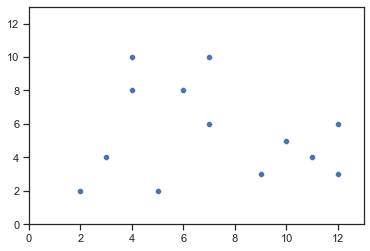

In [17]:
data = [(2, 2), (3, 4), (5, 2), (10, 5), (9, 3),
        (11, 4), (12, 3), (12, 6), (4, 10), (4, 8),
        (6, 8), (7, 10), (7, 6)]

xs, ys = zip(*data) # zipの逆操作

# 可視化
ax = sns.scatterplot(x=xs, y=ys)
ax.set_xlim(0, 13)
ax.set_ylim(0, 13)
plt.show()

(C3-Q2)=
### Q2: 距離/類似度の解釈

Q1で扱ったデータ集合において，点$v=(11, 4)$との最も類似する点（最近傍点）を求めたい．
ユークリッド空間の各次元の意味，最近傍点の定義が下記のような設定である場合，点の類似性を評価する関数としてユークリッド距離，コサイン類似度のどちらを用いるのが適切か考察しながら，最近傍点を求めなさい．

1. 各点は都市の位置情報を表しており，第1次元は「緯度」，第2次元は「経度」を意味する．最近傍点として，**物理的距離が近い都市**を見つけたいケース．
2. 各点はユーザの購買傾向を表しており，第1次元は「ジャンルAに属する商品を購入した回数」，第2次元は「ジャンルBに属する商品を購入した回数」を意味する．最近傍点として，**購買傾向が似ているユーザ**を見つけたいケース．

(C3-Q3)=
### Q3: ポケモンデータ再び
[第1章pandas入門](content/introduction-to-pandas.ipynb)のクイズ課題で用いたデータセット[pokemonData](https://github.com/lgreski/pokemonData)を再度ダウンロードし，その内容をpandasデータフレームに変換して変数`pokemon_df`に代入しなさい．

その上で，データフレーム`pokemon_df`から属性`HP`，`Attack`，`Defense`，`Sp. Atk`，`Sp. Def`，`Speed`の値だけを抽出し，データフレームの最初の5件だけを表示しなさい．


(C3-Q4)=
### Q4: K-means
Q3で準備したデータフレーム`pokenmon_df`とK-meansクラスタリング手法を用いて，第1世代ポケモンを7グループに分けたい．
属性`HP`，`Attack`，`Defense`，`Sp. Atk`，`Sp. Def`，`Speed`のみに注目して，第1世代ポケモンデータにK-meansクラスタリングを適用しなさい．

(C3-Q5)=
### Q5: クラスタの特徴
Q4で求めた各クラスタに含まれるポケモンデータの`HP`，`Attack`，`Defense`，`Sp. Atk`，`Sp. Def`，`Speed`の平均値を求めなさい．

(C3-Q6)=
### Q6: 階層的クラスタリング結果の比較

Q1で扱った13個のデータ点について，階層的クラスタリング法を用いて段階的にクラスタに分割したい．

``scipy.cluster.hierarchy``ライブラリの``linkage``関数および``dendrogram``関数を用いて，Q1で扱ったデータに階層的クラスタリングを適用しなさい．
その際，階層的クラスタリングのクラスタ生成手法として下記3つの方法を用いて，クラスタの生成過程を結果を比較しなさい：

* セントロイド法（centroid）
* 最短距離法（single linkage）
* 最長距離法（complete linkage）

なお，クラスタ間の距離の尺度にはユークリッド距離を用いること．